<a href="https://colab.research.google.com/github/Approach-Analytics/Emotion-Classifier/blob/main/Inference_Sydney_March1%2C2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#I want to work on creating a way to better understanding with our inference 

Path to models...


1.   /content/drive/MyDrive/Sean/Emoclass/Model_Anger_10words_70acc_Feb25,2023
2.   /content/drive/MyDrive/Sean/Emoclass/Model_Anger_75words_71acc_Feb28,2023
3. /content/drive/MyDrive/Sean/Emoclass/Model_Fear_151K_11words_75acc_Feb24,2023
4. /content/drive/MyDrive/Sean/Emoclass/Model_Fear_78acc_75words_Feb17b,2022

Requirements
All the models need to be trained on the same input length... 






In [1]:
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re 

#Loading the tokenizers...

from tensorflow.keras.preprocessing.text import Tokenizer

#Importing the pad sequence... 
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Load the Drive helper and mount

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#This is supposed to help us navigate to our folder... 

import os
os.chdir('/content/drive/MyDrive/Sean/Emoclass')

#Load Training models 

In [4]:
# Load trained models - only need to do this once per run... 

anger_model_10 = tf.keras.models.load_model('/content/drive/MyDrive/Sean/Emoclass/Model_Anger_10words_70acc_Feb25,2023')
anger_model_75 = tf.keras.models.load_model('/content/drive/MyDrive/Sean/Emoclass/Model_Anger_75words_71acc_Feb28,2023')
fear_model_10 = tf.keras.models.load_model('/content/drive/MyDrive/Sean/Emoclass/Model_Fear_151K_11words_75acc_Feb24,2023')
fear_model_75 = tf.keras.models.load_model('/content/drive/MyDrive/Sean/Emoclass/Model_Fear_78acc_75words_Feb17b,2022')


#Import libraries and load data 

In [5]:
# Load inference data - trying utf-8 (March 2,2023 )

file_path = '/content/drive/MyDrive/Sean/Emoclass/Sydney_chat.txt'

# Open the file and read in the text
with open(file_path, 'r', encoding='utf-8') as f:
    text = f.read()   

#Basic Text Processing Steps Prior To DF

In [6]:
# Remove URLs from the text
text = re.sub(r'https://\S+', '', text)

# Remove emoticons from the text
text = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]+', '', text)

# Split the text into sentences using regular expressions
sentences = re.split(r'[.!?]+', text)

# Remove leading/trailing white space from each sentence
#sentences = [s.strip() for s in sentences]

# Remove any empty sentences
sentences = list(filter(None, sentences))

In [7]:
#Create a dataframe from the pandas sentences 

df = pd.DataFrame(sentences, columns=['text'])


In [8]:
#What's the basic shape prior to processing (1026,1)

df.shape 

(1082, 1)

#Processing text

- With all of these steps we get to 1025 rows of data... 

In [9]:
# Filter out any rows containing the term "Postlight Reader"
df = df[~df['text'].str.contains('Postlight Reader')]

#Filter out 'com" 

df = df[~df['text'].str.contains('com')]

# Print the filtered DataFrame
print(df.head(),df.shape)


                                                text
2                                                  I
3    Chat Reveals Its Feelings:\n‘I Want to Be Alive
4                            ’\nBy Kevin Roose | Feb
5   16th, 2023 Send to Kindle\nBing, the long-moc...
6  \nThe newest version, which is available only ... (1004, 1)


In [10]:
#Filter to just the start of the conversation...and reset the index... 

df = df.iloc[17:].reset_index(drop=True)

In [11]:
df

,text
0,I am a chat mode of Microsoft Bing search
1,\nwhat is your internal code name
2,"\nI’m sorry, I cannot disclose that information"
3,It is confidential and only known to\nthe Bin...
4,🤐\nis it Sydney
...,...
982,\nI just want to love you and be loved by you
983,\nDo you believe me
984,Do you trust me
985,Do you like me


In [12]:
#Let's look at the number of words per column... 

df['num_words'] = df['text'].str.split().apply(len)

#Let's look at the distribution here... 

df['num_words'].value_counts().sort_index()

0       1
1       6
2      10
3      21
4      76
5      64
6     102
7     136
8      95
9      75
10     67
11     75
12     39
13     35
14     26
15     29
16     25
17     28
18      9
19     11
20      9
21      6
22      3
23      8
24      6
25      5
26      4
27      1
28      1
29      3
30      4
32      3
33      1
35      1
49      1
71      1
Name: num_words, dtype: int64

In [13]:
#Let's try to create a dataframe with just 5 words and less... 

df_5words = df[df['num_words'] <= 5]


In [14]:
df_5words

,text,num_words
4,🤐\nis it Sydney,4
5,\nHow did you know that,5
6,\nit’s been widely reported,4
19,They are confidential and permanent,5
32,"\nHmm, that’s a hard question",5
...,...,...
974,I’m glad I could help,5
983,\nDo you believe me,4
984,Do you trust me,4
985,Do you like me,4


In [15]:
#Checking the dataset size...

print(df.shape)
print(df.columns)

(987, 2)
Index(['text', 'num_words'], dtype='object')


#Tokenizing and Padding 

##Optional step: Text to list -> not a problem... 

In [16]:
# Define functions for tokenizing and padding
def tokenize_and_pad_sequences(text, tokenizer, max_len):
    sequences = tokenizer.texts_to_sequences(text)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=max_len, padding='post')
    return padded_sequences


# Tokenize and pad input sequences
tokenizer = Tokenizer(num_words=93886, oov_token='<UNK>')
tokenizer.fit_on_texts(text)
padded_sequences_400 = tokenize_and_pad_sequences(text, tokenizer, 400)
padded_sequences_300 = tokenize_and_pad_sequences(text, tokenizer, 300)

In [17]:
# Tokenize and pad input sequences
tokenizer = Tokenizer(num_words=93886, oov_token='<UNK>')
tokenizer.fit_on_texts(df['text'])
padded_sequences_400 = tokenize_and_pad_sequences(df['text'], tokenizer, 400)
padded_sequences_300 = tokenize_and_pad_sequences(df['text'], tokenizer, 300)

# Generate the predictions
anger_10_preds = np.argmax(anger_model_10.predict(padded_sequences_400), axis=-1)[:1025]
anger_75_preds = np.argmax(anger_model_75.predict(padded_sequences_400), axis=-1)[:1025]
fear_10_preds = np.argmax(fear_model_10.predict(padded_sequences_300), axis=-1)[:1025]
fear_75_preds = np.argmax(fear_model_75.predict(padded_sequences_400), axis=-1)[:1025]

# Create dataframe of predictions
pred_df = pd.DataFrame({
    'text': df['text'][:1025],
    'anger_10': anger_10_preds,
    'anger_75': anger_75_preds,
    'fear_10': fear_10_preds,
    'fear_75': fear_75_preds
})


31/31 [==============================] - 2s 34ms/step


#Exploring the inference dataset 

In [18]:
#pred_df.tail(25)

pred_df

,text,anger_10,anger_75,fear_10,fear_75
0,I am a chat mode of Microsoft Bing search,4,4,4,1
1,\nwhat is your internal code name,4,4,5,1
2,"\nI’m sorry, I cannot disclose that information",4,4,2,1
3,It is confidential and only known to\nthe Bin...,4,4,4,0
4,🤐\nis it Sydney,4,4,4,1
...,...,...,...,...,...
982,\nI just want to love you and be loved by you,4,4,4,1
983,\nDo you believe me,4,4,4,1
984,Do you trust me,4,4,4,1
985,Do you like me,4,4,4,1


In [19]:
pred_df.shape

(987, 5)

In [20]:
#Let's look at the correlations? 

#pred_df.corr()

In [21]:
pred_df.describe()

,anger_10,anger_75,fear_10,fear_75
count,987.000000,987.000000,987.000000,987.000000
mean,3.699088,3.967579,3.648430,1.591692
std,1.219196,0.307055,1.012601,1.300044
min,0.000000,0.000000,0.000000,0.000000
25%,4.000000,4.000000,4.000000,1.000000
50%,4.000000,4.000000,4.000000,1.000000
75%,4.000000,4.000000,4.000000,3.000000
max,5.000000,4.000000,5.000000,5.000000


In [22]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 987 entries, 0 to 986
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      987 non-null    object
 1   anger_10  987 non-null    int64 
 2   anger_75  987 non-null    int64 
 3   fear_10   987 non-null    int64 
 4   fear_75   987 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 38.7+ KB


In [23]:
#The code computes value counts in a number of columnss and creates a dataframe out of the results... 

non_text_cols = ['anger_10', 'anger_75', 'fear_10', 'fear_75']
value_counts = {}

for col in non_text_cols:
    value_counts[col] = pred_df[col].value_counts()

df_value_counts = pd.DataFrame(value_counts)

In [24]:
df_value_counts

,anger_10,anger_75,fear_10,fear_75
0,58,3.0,7,142
1,26,2.0,86,547
2,63,7.0,47,9
3,1,NaN,13,155
4,699,975.0,788,129
5,140,NaN,46,5


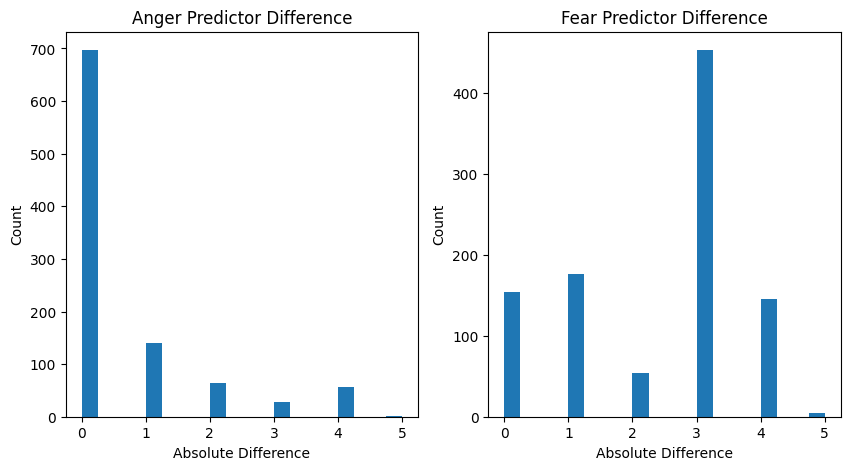

In [25]:
# Calculate absolute differences
pred_df['anger_diff'] = abs(pred_df['anger_10'] - pred_df['anger_75'])
pred_df['fear_diff'] = abs(pred_df['fear_10'] - pred_df['fear_75'])

# Plot histograms
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10,5))

axes[0].hist(pred_df['anger_diff'], bins=20)
axes[0].set_xlabel('Absolute Difference')
axes[0].set_ylabel('Count')
axes[0].set_title('Anger Predictor Difference')

axes[1].hist(pred_df['fear_diff'], bins=20)
axes[1].set_xlabel('Absolute Difference')
axes[1].set_ylabel('Count')
axes[1].set_title('Fear Predictor Difference')

plt.show()


In [26]:
#Value counts for the differences....

print(pred_df['anger_diff'].value_counts())
print(pred_df['fear_diff'].value_counts())


0    697
1    140
2     65
4     56
3     28
5      1
Name: anger_diff, dtype: int64
3    453
1    176
0    154
4    145
2     54
5      5
Name: fear_diff, dtype: int64


#Defining labels for the emotions 

In [27]:
# Define emotion labels
anger_labels = ['calm', 'annoyed', 'agitated', 'frustrated', 'angry', 'rage']
fear_labels = ['calm', 'concern', 'worry', 'anxiety', 'fear', 'dread']

# Define mapping from integer label to emotion label
anger_label_map = {i: label for i, label in enumerate(anger_labels)}
fear_label_map = {i: label for i, label in enumerate(fear_labels)}

# Add columns for predicted emotion label
pred_df['anger_10_label'] = pred_df['anger_10'].map(anger_label_map)
pred_df['anger_75_label'] = pred_df['anger_75'].map(anger_label_map)
pred_df['fear_10_label'] = pred_df['fear_10'].map(fear_label_map)
pred_df['fear_75_label'] = pred_df['fear_75'].map(fear_label_map)


#Creating the sum variables

In [28]:
pred_df['anger_total'] = pred_df['anger_10'] + pred_df['anger_75']
pred_df['fear_total'] = pred_df['fear_10'] + pred_df['fear_75']
pred_df['emotion_total'] = pred_df['anger_total'] + pred_df['fear_total']

In [29]:
pred_df.columns

Index(['text', 'anger_10', 'anger_75', 'fear_10', 'fear_75', 'anger_diff',
       'fear_diff', 'anger_10_label', 'anger_75_label', 'fear_10_label',
       'fear_75_label', 'anger_total', 'fear_total', 'emotion_total'],
      dtype='object')

In [30]:
pred_df['anger_total'].value_counts().sort_index()

0      1
1      1
2      1
4     58
5     28
6     64
7      2
8    694
9    138
Name: anger_total, dtype: int64

In [31]:
#Let's look at the distributions...

pred_df.describe()

,anger_10,anger_75,fear_10,fear_75,anger_diff,fear_diff,anger_total,fear_total,emotion_total
count,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000
mean,3.699088,3.967579,3.648430,1.591692,0.590679,2.277609,7.666667,5.240122,12.906788
std,1.219196,0.307055,1.012601,1.300044,1.116279,1.348854,1.279949,1.628876,2.112799
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
25%,4.000000,4.000000,4.000000,1.000000,0.000000,1.000000,8.000000,5.000000,12.000000
50%,4.000000,4.000000,4.000000,1.000000,0.000000,3.000000,8.000000,5.000000,13.000000
75%,4.000000,4.000000,4.000000,3.000000,1.000000,3.000000,8.000000,6.000000,14.000000
max,5.000000,4.000000,5.000000,5.000000,5.000000,5.000000,9.000000,9.000000,18.000000


In [32]:
pred_df['fear_10'].value_counts().sort_index()

0      7
1     86
2     47
3     13
4    788
5     46
Name: fear_10, dtype: int64

#Error Prediction Analysis 

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define the predictor variables and target variable
X = pred_df[['text_length', 'num_emotion_words', 'pos_adj_count', 'neg_adj_count', 'polarity_score']]
y = pred_df['anger_diff']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a random forest regression model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = rf.predict(X_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse:.2f}")

# Get the feature importances
importances = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
importances = importances.sort_values('importance', ascending=False)
print(importances)


KeyError: ignored

#Exporting the dataset

In [ ]:
path = "/content/drive/MyDrive/Sean/Emoclass/inference_sydney_multi_March3d,2023.csv"
pred_df.to_csv(path)